In [68]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt

import seaborn as sns

from numpy import dtype

from sklearn.compose import ColumnTransformer

from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor


from sklearn.pipeline import make_pipeline, Pipeline

# Encoders
from sklearn.preprocessing import *


# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer


In [2]:
df_emprestimo = pd.read_csv('C:\\Users\\diogo\\OneDrive\\Documentos\\Profissional\\ml_2\\aprovacao_credito_previsao\\credit_risk_dataset.csv')
df_emprestimo.head(10)

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   
5          21           9900                   OWN                2.0   
6          26          77100                  RENT                8.0   
7          24          78956                  RENT                5.0   
8          24          83000                  RENT                8.0   
9          21          10000                   OWN                6.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   
5     VENTURE          A       2500           7.14            1   
6   EDUCATION          B      35000          12.42            1   
7     MEDICAL          B      35000          11.11            1   
8    PERSONAL          A      35000           8.90            1   
9     VENTURE          D       1600          14.74            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4  
5                 0.25                         N                           2  
6                 0.45                         N                           3  
7                 0.44                         N                           4  
8                 0.42                         N                           2  
9                 0.16                         N                           3

In [3]:
# Rearranjando para colocar o target no local certo
df_emprestimo = df_emprestimo[['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate','loan_percent_income',
                                'cb_person_default_on_file', 'cb_person_cred_hist_length' ,'loan_status']]

# Renomeando as colunas para melhor entendimento do problema

df_emprestimo.columns = ['idade', 'renda', 'moradia', 'tempo_empregado', 'motivo_emp', 'risco_emp',
                          'valor_emp', 'taxa_juros', 'emp/renda', 'hist_inadimplencia', 'tempo_emp_hist', 'sts_emp']

In [4]:
# Começando as análises por colunas, iremos trabalhar olhando para o dataset no geral
df_emprestimo.isna().sum()

idade                    0
renda                    0
moradia                  0
tempo_empregado        895
motivo_emp               0
risco_emp                0
valor_emp                0
taxa_juros            3116
emp/renda                0
hist_inadimplencia       0
tempo_emp_hist           0
sts_emp                  0
dtype: int64

In [5]:
#percebemos que há uma necessidade de tratamento para as colunas de taxa de juros e de tempo empregado, esses valores serão tratados no futuro

In [6]:
# Realizando uma Análise Exploratória dos Dados
df_emprestimo.describe()

idade         renda  tempo_empregado     valor_emp  \
count  32581.000000  3.258100e+04     31686.000000  32581.000000   
mean      27.734600  6.607485e+04         4.789686   9589.371106   
std        6.348078  6.198312e+04         4.142630   6322.086646   
min       20.000000  4.000000e+03         0.000000    500.000000   
25%       23.000000  3.850000e+04         2.000000   5000.000000   
50%       26.000000  5.500000e+04         4.000000   8000.000000   
75%       30.000000  7.920000e+04         7.000000  12200.000000   
max      144.000000  6.000000e+06       123.000000  35000.000000   

         taxa_juros     emp/renda  tempo_emp_hist       sts_emp  
count  29465.000000  32581.000000    32581.000000  32581.000000  
mean      11.011695      0.170203        5.804211      0.218164  
std        3.240459      0.106782        4.055001      0.413006  
min        5.420000      0.000000        2.000000      0.000000  
25%        7.900000      0.090000        3.000000      0.000000  
50%       10.990000      0.150000        4.000000      0.000000  
75%       13.470000      0.230000        8.000000      0.000000  
max       23.220000      0.830000       30.000000      1.000000

In [7]:
# Notamos que existem alguns dados que estão incorretos, como uma idade máxima de 144 anos e tempo empregado de 123 anos, iremos nos aprofundar nesses valores. 

(array([4.877e+03, 7.438e+03, 7.652e+03, 3.541e+03, 3.422e+03, 1.565e+03,
        1.646e+03, 6.750e+02, 7.000e+02, 3.050e+02, 2.960e+02, 1.240e+02,
        1.270e+02, 5.400e+01, 5.000e+01, 2.400e+01, 3.100e+01, 1.000e+01,
        1.900e+01, 5.000e+00, 7.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00]),
 array([ 20.  ,  22.48,  24.96,  27.44,  29.92,  32.4 ,  34.88,  37.36,
         39.84,  42.32,  44.8 ,  47.28,  49.76,  52.24,  54.72,  57.2 ,
         59.68,  62.16,  64.64,  67.12,  69.6 ,  72.08,  74.56,  77.04,
         79.52,  82.  ,  84.48,  86.96,  89.44,  91.92,  94.4 ,  96.88,
         99.36, 101.84, 104.32, 106.8 , 109.28, 111.76, 114.24, 116.72,
        119.2 , 

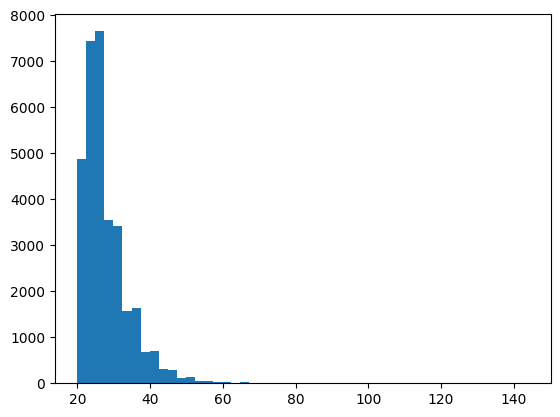

In [8]:
plt.hist(df_emprestimo.idade, bins = 50)

{'whiskers': [<matplotlib.lines.Line2D at 0x160ab1cf200>,
 'caps': [<matplotlib.lines.Line2D at 0x160ac3eb1a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x160ac3eaab0>],
 'medians': [<matplotlib.lines.Line2D at 0x160ac3eb710>],
 'fliers': [<matplotlib.lines.Line2D at 0x160ac3eb980>],
 'means': []}

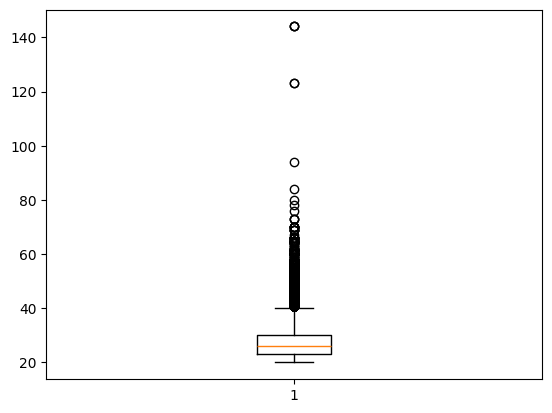

In [9]:
plt.boxplot(df_emprestimo.idade)

In [10]:
# Tratando os outliers
df_emprestimo[df_emprestimo['idade']>90]

idade    renda   moradia  tempo_empregado motivo_emp risco_emp  \
81       144   250000      RENT              4.0    VENTURE         C   
183      144   200000  MORTGAGE              4.0  EDUCATION         B   
575      123    80004      RENT              2.0  EDUCATION         B   
747      123    78000      RENT              7.0    VENTURE         B   
32297    144  6000000  MORTGAGE             12.0   PERSONAL         C   
32416     94    24000      RENT              1.0    MEDICAL         C   

       valor_emp  taxa_juros  emp/renda hist_inadimplencia  tempo_emp_hist  \
81          4800       13.57       0.02                  N               3   
183         6000       11.86       0.03                  N               2   
575        20400       10.25       0.25                  N               3   
747        20000         NaN       0.26                  N               4   
32297       5000       12.73       0.00                  N              25   
32416       6500         NaN       0.27                  N              27   

       sts_emp  
81           0  
183          0  
575          0  
747          0  
32297        0  
32416        0

In [11]:
#como são poucos dados a saída para esses casos será excluí-los do dataset, temos dentre esses valores o valor da renda máxima também que foge muito da média e da banda de 75%
#Tambem podemos notar que a distribuição segue próxima do que se espera para uma distribuição de idade

df_emprestimo = df_emprestimo[df_emprestimo['idade']< 95]

In [12]:
df_emprestimo.describe()

idade         renda  tempo_empregado     valor_emp  \
count  32576.000000  3.257600e+04     31681.000000  32576.000000   
mean      27.718044  6.588214e+04         4.789527   9589.117755   
std        6.204990  5.253499e+04         4.142706   6321.886846   
min       20.000000  4.000000e+03         0.000000    500.000000   
25%       23.000000  3.850000e+04         2.000000   5000.000000   
50%       26.000000  5.500000e+04         4.000000   8000.000000   
75%       30.000000  7.920000e+04         7.000000  12200.000000   
max       94.000000  2.039784e+06       123.000000  35000.000000   

         taxa_juros     emp/renda  tempo_emp_hist       sts_emp  
count  29461.000000  32576.000000    32576.000000  32576.000000  
mean      11.011547      0.170212        5.803966      0.218197  
std        3.240623      0.106778        4.053791      0.413029  
min        5.420000      0.000000        2.000000      0.000000  
25%        7.900000      0.090000        3.000000      0.000000  
50%       10.990000      0.150000        4.000000      0.000000  
75%       13.470000      0.230000        8.000000      0.000000  
max       23.220000      0.830000       30.000000      1.000000

(array([1.0985e+04, 1.5009e+04, 4.4950e+03, 1.2120e+03, 4.6700e+02,
        1.4400e+02, 9.2000e+01, 5.4000e+01, 2.4000e+01, 2.0000e+01,
        1.0000e+01, 6.0000e+00, 1.0000e+01, 6.0000e+00, 8.0000e+00,
        3.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00, 6.0000e+00,
        2.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   4000.  ,   44715.68,   85431.36,  126147.04,  166862.72,
         207578.4 ,  248294.08,  289009.76,  329725.44,  370441.12,
         411156.8 ,  451872.48,  492588.16,  533303.84,  574019.52,
         614735.2 ,  655450.88,  696166.56,  736882.24,  777597.92,
         818313.6 ,  859029.28,  899744.96,  9

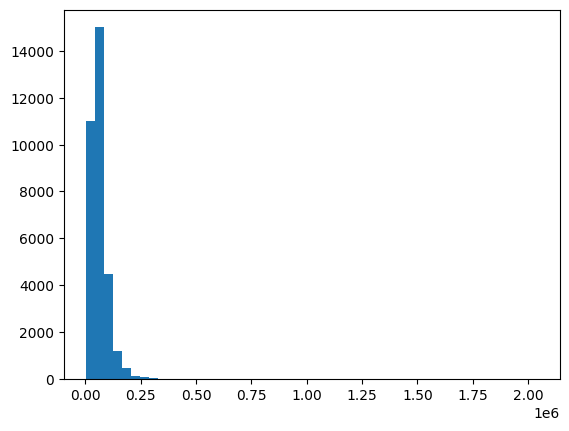

In [13]:
plt.hist(df_emprestimo['renda'], bins=50)

In [14]:
df_emprestimo[df_emprestimo['tempo_empregado'] >20].sort_values(ascending=False, by='tempo_empregado')

idade   renda   moradia  tempo_empregado motivo_emp risco_emp  \
0         22   59000      RENT            123.0   PERSONAL         D   
210       21  192000  MORTGAGE            123.0    VENTURE         A   
32355     78   48000      RENT             41.0    MEDICAL         A   
32515     53  106000  MORTGAGE             38.0   PERSONAL         B   
32428     58   49000  MORTGAGE             34.0    MEDICAL         D   
...      ...     ...       ...              ...        ...       ...   
31685     36  120000       OWN             21.0   PERSONAL         D   
31763     36  140000  MORTGAGE             21.0   PERSONAL         A   
31839     37  145124  MORTGAGE             21.0   PERSONAL         B   
31864     38  175000  MORTGAGE             21.0    VENTURE         B   
31463     37   96996  MORTGAGE             21.0   PERSONAL         A   

       valor_emp  taxa_juros  emp/renda hist_inadimplencia  tempo_emp_hist  \
0          35000       16.02       0.59                  Y               3   
210        20000        6.54       0.10                  N               4   
32355       3000        7.51       0.06                  N              25   
32515      20000        9.88       0.19                  N              23   
32428       7500       13.55       0.15                  Y              24   
...          ...         ...        ...                ...             ...   
31685      10000       13.30       0.08                  Y              13   
31763       8000        6.99       0.06                  N              11   
31839      11375       10.99       0.08                  N              14   
31864      10000       11.26       0.06                  N              17   
31463      13000         NaN       0.13                  N              13   

       sts_emp  
0            1  
210          0  
32355        0  
32515        0  
32428        1  
...        ...  
31685        0  
31763        0  
31839        1  
31864        0  
31463        0  

[111 rows x 12 columns]

In [15]:
# Nota-se que as duas primeiras linhas estão com dados incosistentes, temos duas pessoas com mais tempo empregado do que tem de idade, iremos aprofundar para essa faixa

df_emprestimo[df_emprestimo['idade']<23].groupby('idade')['tempo_empregado'].value_counts()

idade  tempo_empregado
20     4.0                  10
       3.0                   3
       0.0                   1
       1.0                   1
21     5.0                 434
       2.0                 185
       0.0                 183
       3.0                 143
       1.0                  87
       4.0                  81
       6.0                  64
       123.0                 1
22     6.0                1084
       0.0                 473
       2.0                 441
       3.0                 415
       1.0                 356
       4.0                 317
       5.0                 272
       7.0                 160
       123.0                 1
Name: count, dtype: int64

In [16]:
# Apesar dos valores serem totalmente incosistentes,entende-se que por serem dados sintéticos para garantir a anonimatização do dataset
# não há a necessidade de tratamento. Apenas para os valores muito acima de 123 que serão trocados

st.mode(df_emprestimo['tempo_empregado'])

ModeResult(mode=0.0, count=4105)

In [17]:
# Também irá realizar o tratamento para os valores nulos que foram apresentados anteriormente
df_emprestimo['tempo_empregado']= df_emprestimo['tempo_empregado'].replace(123, 0)
df_emprestimo['tempo_empregado']= df_emprestimo['tempo_empregado'].fillna(0)

In [18]:
df_emprestimo.isna().sum()

idade                    0
renda                    0
moradia                  0
tempo_empregado          0
motivo_emp               0
risco_emp                0
valor_emp                0
taxa_juros            3115
emp/renda                0
hist_inadimplencia       0
tempo_emp_hist           0
sts_emp                  0
dtype: int64

In [19]:
# Checando os valores novos
df_emprestimo.describe()

idade         renda  tempo_empregado     valor_emp  \
count  32576.000000  3.257600e+04     32576.000000  32576.000000   
mean      27.718044  6.588214e+04         4.650387   9589.117755   
std        6.204990  5.253499e+04         4.055226   6321.886846   
min       20.000000  4.000000e+03         0.000000    500.000000   
25%       23.000000  3.850000e+04         2.000000   5000.000000   
50%       26.000000  5.500000e+04         4.000000   8000.000000   
75%       30.000000  7.920000e+04         7.000000  12200.000000   
max       94.000000  2.039784e+06        41.000000  35000.000000   

         taxa_juros     emp/renda  tempo_emp_hist       sts_emp  
count  29461.000000  32576.000000    32576.000000  32576.000000  
mean      11.011547      0.170212        5.803966      0.218197  
std        3.240623      0.106778        4.053791      0.413029  
min        5.420000      0.000000        2.000000      0.000000  
25%        7.900000      0.090000        3.000000      0.000000  
50%       10.990000      0.150000        4.000000      0.000000  
75%       13.470000      0.230000        8.000000      0.000000  
max       23.220000      0.830000       30.000000      1.000000

In [20]:
df_emprestimo['moradia'].value_counts()

moradia
RENT        16443
MORTGAGE    13442
OWN          2584
OTHER         107
Name: count, dtype: int64

In [21]:
#Trocando os valores para portugues para facilitar a visualização

df_emprestimo['moradia'] = df_emprestimo['moradia'].replace('RENT', 'aluguel')
df_emprestimo['moradia'] = df_emprestimo['moradia'].replace('MORTGAGE', 'financiamento')
df_emprestimo['moradia'] = df_emprestimo['moradia'].replace('OWN', 'propria')
df_emprestimo['moradia'] = df_emprestimo['moradia'].replace('OTHER', 'outro')

In [22]:
df_emprestimo['sts_emp'].value_counts()

sts_emp
0    25468
1     7108
Name: count, dtype: int64

In [23]:
df_emprestimo.groupby('sts_emp')['moradia'].value_counts(normalize=True).unstack()

moradia   aluguel  financiamento     outro   propria
sts_emp                                             
0        0.441770       0.461442  0.002906  0.093883
1        0.730445       0.237760  0.004643  0.027153

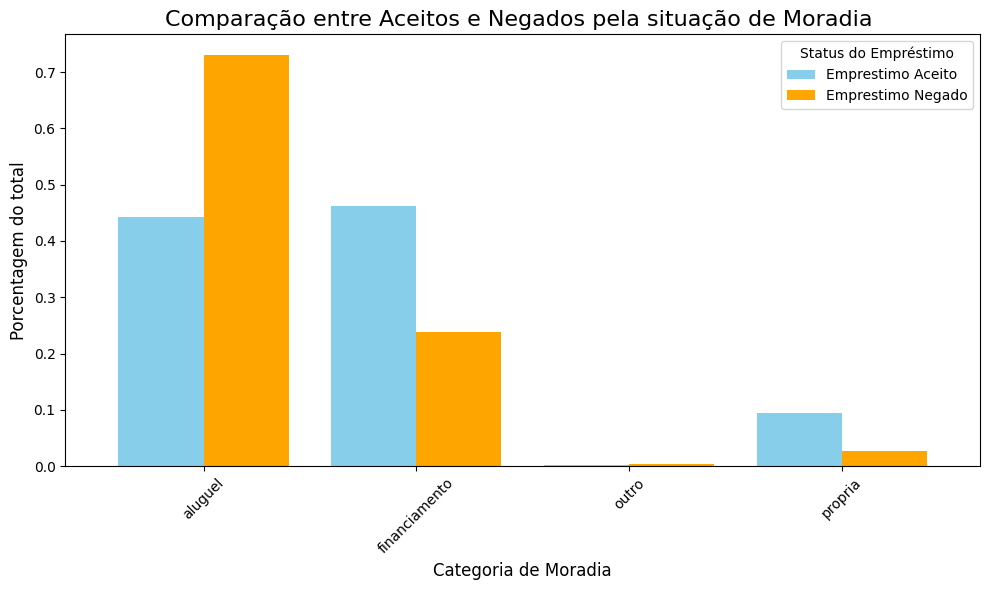

In [24]:
df = df_emprestimo.groupby('sts_emp')['moradia'].value_counts(normalize=True).unstack()

# Configurando o gráfico
ax = df.T.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], width=0.8)

# Personalizando o gráfico
ax.set_title("Comparação entre Aceitos e Negados pela situação de Moradia ", fontsize=16)
ax.set_xlabel("Categoria de Moradia", fontsize=12)
ax.set_ylabel("Porcentagem do total", fontsize=12)
ax.legend(["Emprestimo Aceito", "Emprestimo Negado"], title="Status do Empréstimo")
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()

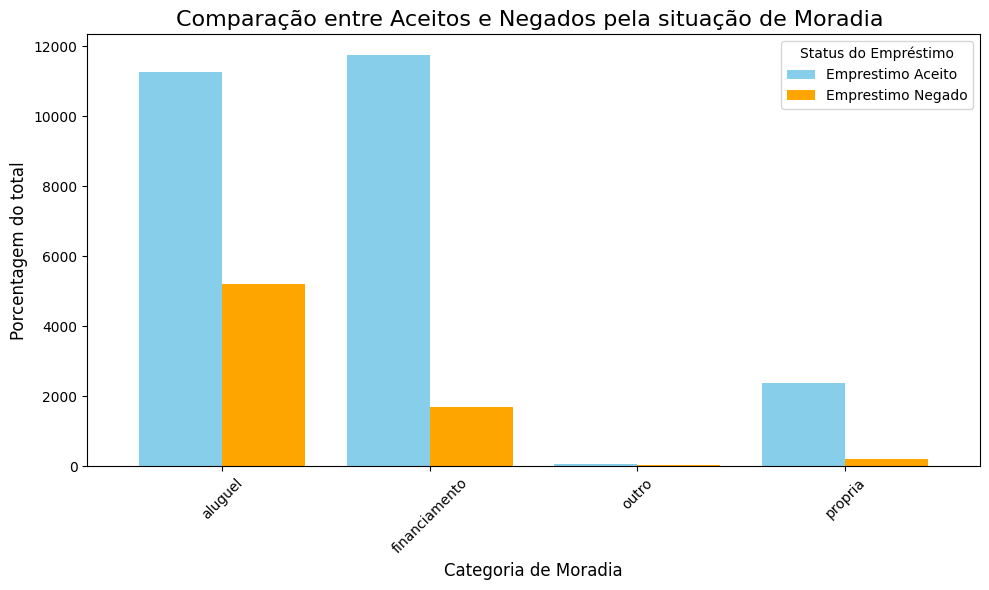

In [25]:
df3 = df_emprestimo.groupby('sts_emp')['moradia'].value_counts().unstack()

# Configurando o gráfico
ax = df3.T.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], width=0.8)

# Personalizando o gráfico
ax.set_title("Comparação entre Aceitos e Negados pela situação de Moradia ", fontsize=16)
ax.set_xlabel("Categoria de Moradia", fontsize=12)
ax.set_ylabel("Porcentagem do total", fontsize=12)
ax.legend(["Emprestimo Aceito", "Emprestimo Negado"], title="Status do Empréstimo")
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [26]:
# Podemos notar que essa é uma Feature importante para determinar se o empréstimo será aceito ou não
# Faremos a substituição para o motivo também e iremos analisar
df_emprestimo['motivo_emp'].value_counts()


motivo_emp
EDUCATION            6451
MEDICAL              6071
VENTURE              5717
PERSONAL             5520
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64

In [27]:
df_emprestimo['motivo_emp'] = df_emprestimo['motivo_emp'].replace('EDUCATION', 'educacao')
df_emprestimo['motivo_emp'] = df_emprestimo['motivo_emp'].replace('MEDICAL', 'saude')
df_emprestimo['motivo_emp'] = df_emprestimo['motivo_emp'].replace('VENTURE', 'investimento')
df_emprestimo['motivo_emp'] = df_emprestimo['motivo_emp'].replace('PERSONAL', 'pessoal')
df_emprestimo['motivo_emp'] = df_emprestimo['motivo_emp'].replace('DEBTCONSOLIDATION', 'consolidacao_dividas')
df_emprestimo['motivo_emp'] = df_emprestimo['motivo_emp'].replace('HOMEIMPROVEMENT', 'reforma')


In [28]:
df_emprestimo.groupby('sts_emp')['motivo_emp'].value_counts(normalize=True).unstack()

motivo_emp  consolidacao_dividas  educacao  investimento   pessoal   reforma  \
sts_emp                                                                        
0                       0.146144  0.209675      0.191220  0.173630  0.104602   
1                       0.209623  0.156303      0.119162  0.154474  0.132386   

motivo_emp     saude  
sts_emp               
0           0.174729  
1           0.228053

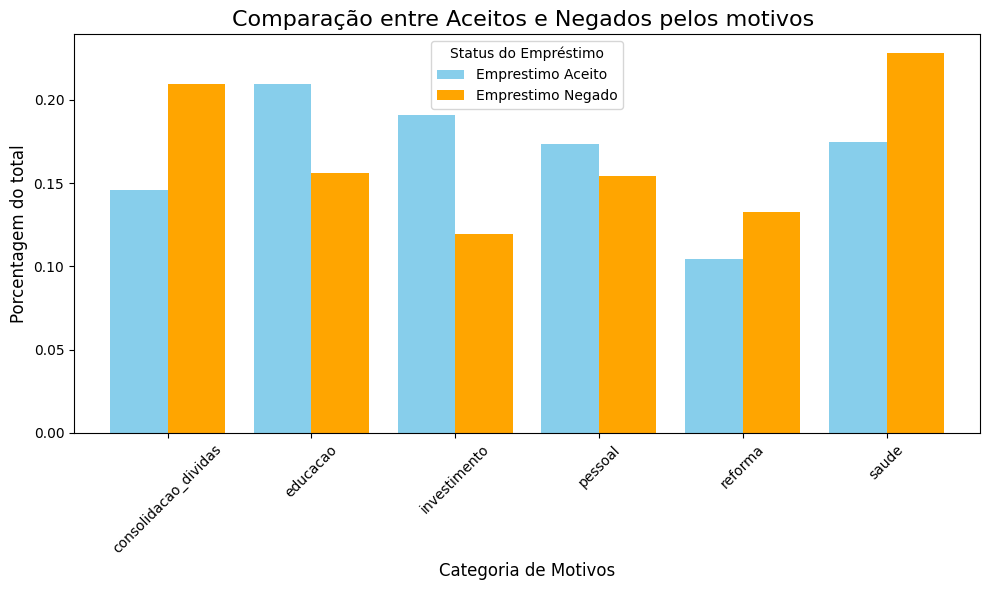

In [29]:
df2 = df_emprestimo.groupby('sts_emp')['motivo_emp'].value_counts(normalize=True).unstack()

# Configurando o gráfico
ax = df2.T.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], width=0.8)

# Personalizando o gráfico
ax.set_title("Comparação entre Aceitos e Negados pelos motivos ", fontsize=16)
ax.set_xlabel("Categoria de Motivos", fontsize=12)
ax.set_ylabel("Porcentagem do total", fontsize=12)
ax.legend(["Emprestimo Aceito", "Emprestimo Negado"], title="Status do Empréstimo")
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()

(array([5.940e+02, 1.213e+03, 2.770e+02, 8.430e+02, 1.172e+03, 1.917e+03,
        1.754e+03, 2.120e+02, 6.690e+02, 8.380e+02, 3.530e+02, 5.520e+02,
        1.308e+03, 1.016e+03, 1.296e+03, 1.182e+03, 8.190e+02, 1.290e+03,
        1.258e+03, 9.690e+02, 1.135e+03, 1.161e+03, 1.055e+03, 7.120e+02,
        9.940e+02, 6.900e+02, 7.430e+02, 7.250e+02, 5.110e+02, 5.260e+02,
        3.940e+02, 3.040e+02, 1.880e+02, 1.770e+02, 1.150e+02, 9.100e+01,
        1.120e+02, 7.900e+01, 7.100e+01, 3.800e+01, 3.400e+01, 2.700e+01,
        9.000e+00, 1.300e+01, 1.300e+01, 6.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 5.42 ,  5.776,  6.132,  6.488,  6.844,  7.2  ,  7.556,  7.912,
         8.268,  8.624,  8.98 ,  9.336,  9.692, 10.048, 10.404, 10.76 ,
        11.116, 11.472, 11.828, 12.184, 12.54 , 12.896, 13.252, 13.608,
        13.964, 14.32 , 14.676, 15.032, 15.388, 15.744, 16.1  , 16.456,
        16.812, 17.168, 17.524, 17.88 , 18.236, 18.592, 18.948, 19.304,
        19.66 , 

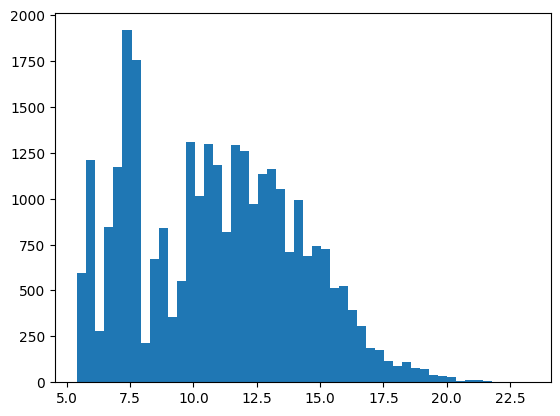

In [30]:
plt.hist(df_emprestimo['taxa_juros'], bins=50)

In [31]:
# Como não há uma distribuição muito clara das taxas de juros, precisamos de uma maneira mais assertiva para preencher os valores faltantes
# Iremos utilizar uma abordagem clusterizar os clientes para buscar taxas de juros mais condizentes para cada cluster. 
# Há também uma avaliação importante que é a % emp/renda que influencia na taxa

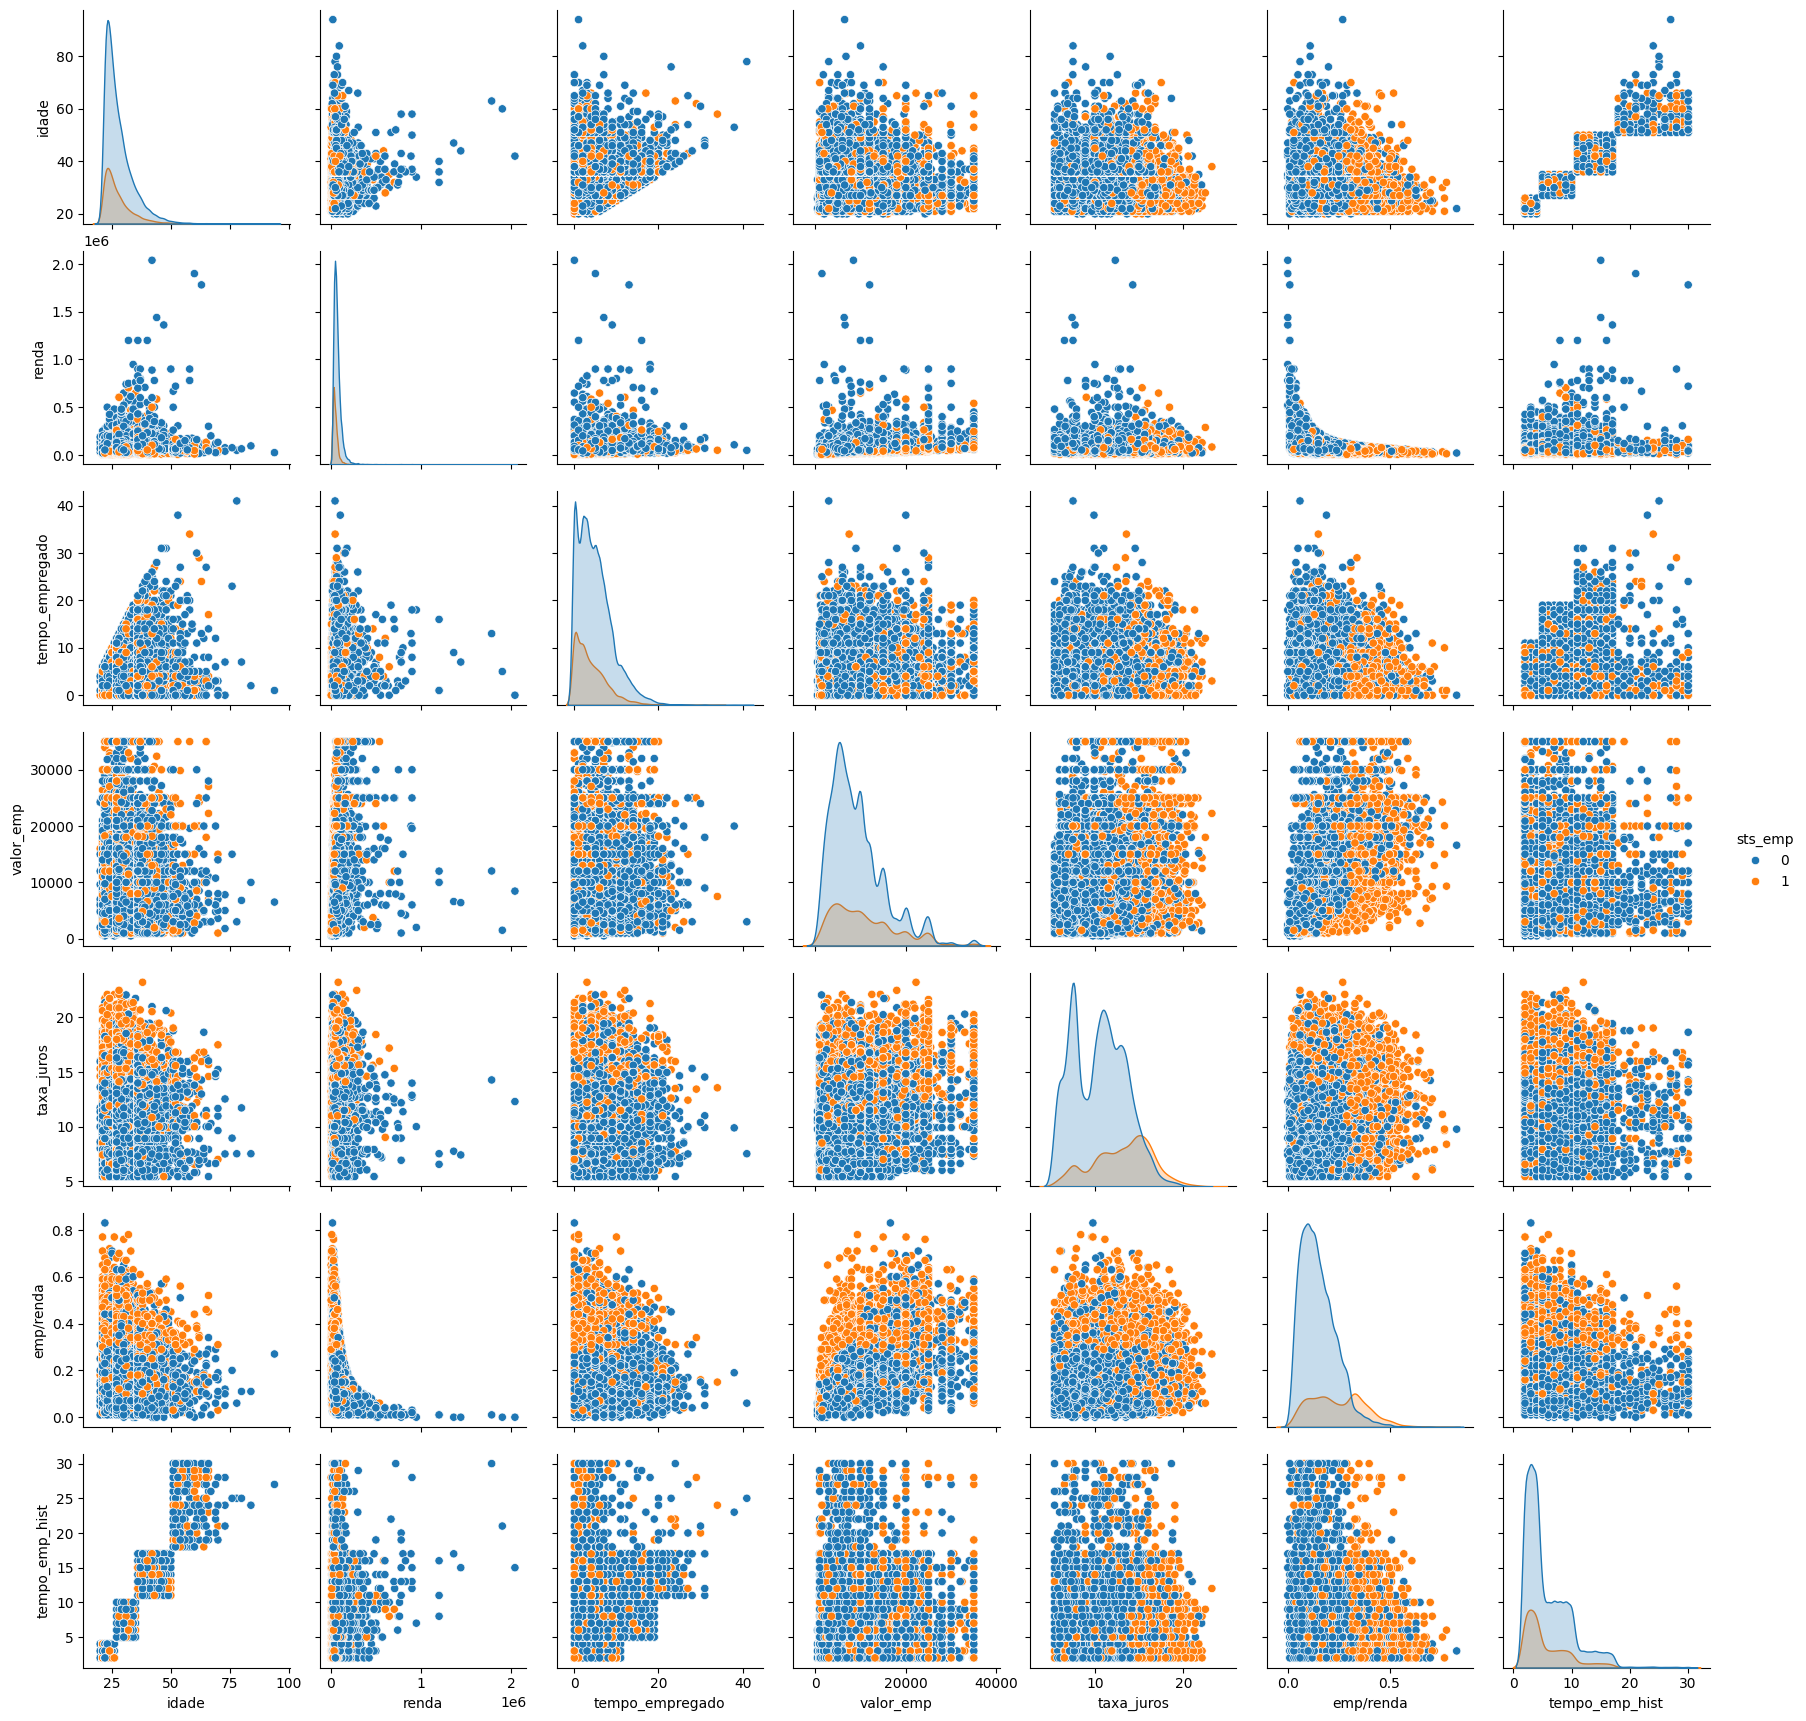

In [32]:
sns.pairplot(df_emprestimo, hue='sts_emp')

(array([ 41., 195., 117., 305., 206., 365., 177., 330., 197., 342., 219.,
        385., 338., 164., 272., 131., 285., 131., 212., 269., 508., 201.,
        341., 120., 274., 246., 119., 132.,  55., 101.,  43.,  92.,  27.,
         58.,  14.,  22.,   9.,  20.,  10.,   1.,  14.,   2.,   6.,   2.,
          3.,   2.,   1.,   0.,   1.,   3.]),
 array([0.01  , 0.0254, 0.0408, 0.0562, 0.0716, 0.087 , 0.1024, 0.1178,
        0.1332, 0.1486, 0.164 , 0.1794, 0.1948, 0.2102, 0.2256, 0.241 ,
        0.2564, 0.2718, 0.2872, 0.3026, 0.318 , 0.3334, 0.3488, 0.3642,
        0.3796, 0.395 , 0.4104, 0.4258, 0.4412, 0.4566, 0.472 , 0.4874,
        0.5028, 0.5182, 0.5336, 0.549 , 0.5644, 0.5798, 0.5952, 0.6106,
        0.626 , 0.6414, 0.6568, 0.6722, 0.6876, 0.703 , 0.7184, 0.7338,
        0.7492, 0.7646, 0.78  ]),
 <BarContainer object of 50 artists>)

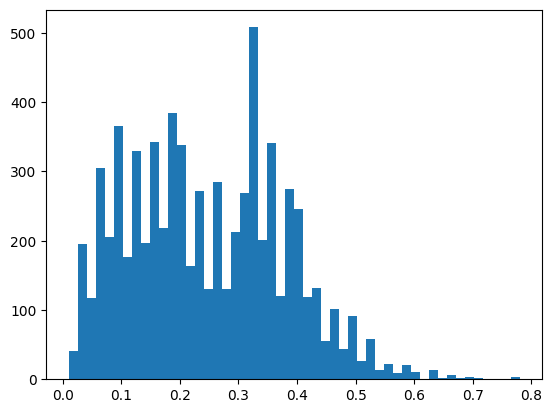

In [33]:
plt.hist(df_emprestimo['emp/renda'][df_emprestimo['sts_emp'] == 1], bins=50)

(array([1.390e+02, 1.040e+03, 8.560e+02, 2.208e+03, 2.462e+03, 1.210e+03,
        2.541e+03, 2.445e+03, 1.097e+03, 2.002e+03, 1.824e+03, 7.730e+02,
        1.583e+03, 1.186e+03, 5.560e+02, 9.370e+02, 7.660e+02, 3.630e+02,
        4.650e+02, 2.310e+02, 7.400e+01, 1.830e+02, 1.220e+02, 5.300e+01,
        8.800e+01, 6.400e+01, 3.500e+01, 4.300e+01, 3.500e+01, 9.000e+00,
        3.600e+01, 1.000e+01, 4.000e+00, 6.000e+00, 3.000e+00, 3.000e+00,
        5.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.    , 0.0166, 0.0332, 0.0498, 0.0664, 0.083 , 0.0996, 0.1162,
        0.1328, 0.1494, 0.166 , 0.1826, 0.1992, 0.2158, 0.2324, 0.249 ,
        0.2656, 0.2822, 0.2988, 0.3154, 0.332 , 0.3486, 0.3652, 0.3818,
        0.3984, 0.415 , 0.4316, 0.4482, 0.4648, 0.4814, 0.498 , 0.5146,
        0.5312, 0.5478, 0.5644, 0.581 , 0.5976, 0.6142, 0.6308, 0.6474,
        0.664 , 

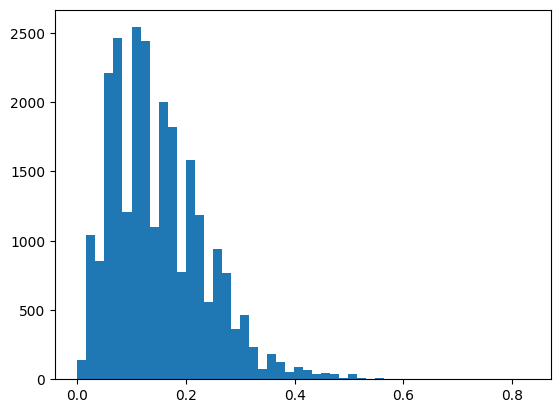

In [34]:
plt.hist(df_emprestimo['emp/renda'][df_emprestimo['sts_emp'] == 0], bins=50)

In [35]:
# Como podemos notar não há uma relação clara entre a aprovação e a % de emp/renda, bem como uma distribuição normal dos valores
# para que podemos imputar diretamente de acordo com uma distribuição. 


In [36]:
df_emprestimo_cluster = df_emprestimo.drop(columns=['sts_emp', 'taxa_juros']).reset_index()

In [37]:
df_emprestimo_cluster

index  idade   renda        moradia  tempo_empregado motivo_emp  \
0          0     22   59000        aluguel              0.0    pessoal   
1          1     21    9600        propria              5.0   educacao   
2          2     25    9600  financiamento              1.0      saude   
3          3     23   65500        aluguel              4.0      saude   
4          4     24   54400        aluguel              8.0      saude   
...      ...    ...     ...            ...              ...        ...   
32571  32576     57   53000  financiamento              1.0    pessoal   
32572  32577     54  120000  financiamento              4.0    pessoal   
32573  32578     65   76000        aluguel              3.0    reforma   
32574  32579     56  150000  financiamento              5.0    pessoal   
32575  32580     66   42000        aluguel              2.0      saude   

      risco_emp  valor_emp  emp/renda hist_inadimplencia  tempo_emp_hist  
0             D      35000       0.59                  Y               3  
1             B       1000       0.10                  N               2  
2             C       5500       0.57                  N               3  
3             C      35000       0.53                  N               2  
4             C      35000       0.55                  Y               4  
...         ...        ...        ...                ...             ...  
32571         C       5800       0.11                  N              30  
32572         A      17625       0.15                  N              19  
32573         B      35000       0.46                  N              28  
32574         B      15000       0.10                  N              26  
32575         B       6475       0.15                  N              30  

[32576 rows x 11 columns]

In [38]:
cat_num = list(df_emprestimo_cluster.select_dtypes(include='number'))
cat_hot = list(df_emprestimo_cluster.select_dtypes(exclude='number'))

In [39]:
s_scaler = StandardScaler()
one_encoder = OneHotEncoder(sparse_output=False)

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, cat_num),
        ('cat', one_encoder, cat_hot)
    ]
)

In [41]:
x_prep = preprocessor.fit_transform(df_emprestimo_cluster)

In [113]:
pca = PCA(n_components= 0.7)

In [114]:
x_red = pca.fit_transform(x_prep)

In [115]:
kmeans = KMeans(n_clusters=4)

In [116]:
kmeans.fit(x_red)

KMeans(n_clusters=4)

In [117]:
kmeans.predict(x_red)

array([0, 2, 0, ..., 3, 3, 3])

In [118]:
labels_clusters = kmeans.labels_

In [119]:
len(labels_clusters)

32576

In [120]:
labels_series = pd.Series(labels_clusters, name = "label")

In [121]:
labels_series.shape[0]

32576

In [122]:
df_emprestimo_cluster.shape[0]

32576

In [123]:
df_cluster_f = pd.concat([df_emprestimo_cluster, labels_series], axis=1)

In [124]:
df_cluster_f

index  idade   renda        moradia  tempo_empregado motivo_emp  \
0          0     22   59000        aluguel              0.0    pessoal   
1          1     21    9600        propria              5.0   educacao   
2          2     25    9600  financiamento              1.0      saude   
3          3     23   65500        aluguel              4.0      saude   
4          4     24   54400        aluguel              8.0      saude   
...      ...    ...     ...            ...              ...        ...   
32571  32576     57   53000  financiamento              1.0    pessoal   
32572  32577     54  120000  financiamento              4.0    pessoal   
32573  32578     65   76000        aluguel              3.0    reforma   
32574  32579     56  150000  financiamento              5.0    pessoal   
32575  32580     66   42000        aluguel              2.0      saude   

      risco_emp  valor_emp  emp/renda hist_inadimplencia  tempo_emp_hist  \
0             D      35000       0.59                  Y               3   
1             B       1000       0.10                  N               2   
2             C       5500       0.57                  N               3   
3             C      35000       0.53                  N               2   
4             C      35000       0.55                  Y               4   
...         ...        ...        ...                ...             ...   
32571         C       5800       0.11                  N              30   
32572         A      17625       0.15                  N              19   
32573         B      35000       0.46                  N              28   
32574         B      15000       0.10                  N              26   
32575         B       6475       0.15                  N              30   

       label  
0          0  
1          2  
2          0  
3          0  
4          0  
...      ...  
32571      3  
32572      3  
32573      3  
32574      3  
32575      3  

[32576 rows x 12 columns]

In [125]:
silhouette_score(x_red, labels_series)

0.23641783217862378

In [ ]:
x_red

array([[-1.95320253,  5.65510182, -0.65612832, -1.0961981 ,  0.90454187],
       [-2.36079523, -1.33148539, -0.24691557,  0.85265018, -0.17668626],
       [-2.17138745,  2.10392072, -2.00612312,  0.3977574 , -0.45248138],
       ...,
       [ 7.46278508,  4.33386443, -2.65317951, -1.31429859,  0.21517439],
       [ 6.73037443, -0.10817225, -0.33386271, -1.22589758, -0.21627097],
       [ 7.37561223, -0.96215175, -3.47398387, -0.86704072,  0.36542601]])

In [129]:
X_df = pd.DataFrame(x_red, columns = [f"X{i+1}" for i in range(x_red.shape[1])])
X_df

X1        X2        X3        X4        X5
0     -1.953203  5.655102 -0.656128 -1.096198  0.904542
1     -2.360795 -1.331485 -0.246916  0.852650 -0.176686
2     -2.171387  2.103921 -2.006123  0.397757 -0.452481
3     -1.761008  5.269097  0.051036 -0.320276  0.550514
4     -1.259274  5.460055  0.078795  0.571380  1.495241
...         ...       ...       ...       ...       ...
32571  6.670775 -1.271225 -2.690366 -1.053798 -0.189042
32572  5.450097  0.469858 -0.428546 -1.053712 -0.703279
32573  7.462785  4.333864 -2.653180 -1.314299  0.215174
32574  6.730374 -0.108172 -0.333863 -1.225898 -0.216271
32575  7.375612 -0.962152 -3.473984 -0.867041  0.365426

[32576 rows x 5 columns]

In [130]:
dbscan = DBSCAN()
dbscan.fit(X_df)

DBSCAN()

In [131]:
dbscan.labels_

array([-1,  0,  0, ..., -1, -1, -1], dtype=int64)

In [132]:
def plot_dbscan(X_df, eps, min_pts):
     # Instanciamento e fit do modelo
    dbscan = DBSCAN(eps = eps, min_samples = min_pts)
    dbscan.fit(X_df)

    # ========================================
    # estruturação dos resultados
    labels_clusters = dbscan.labels_
    labels_series = pd.Series(labels_clusters, name="label")

    df_result = pd.concat([X_df, labels_series], axis=1)
    n_clusters = pd.Series(labels_clusters).nunique()

    # ========================================
    print(f"DBSCAN com eps={eps} e minPts={min_pts}\nNúmero de clusters: {n_clusters}")
    sns.scatterplot(data=df_result, x="X1", y="X2", hue="label", palette="tab10")
    plt.show()

    print("Quantidade de pontos em cada clusters:")
    print(pd.Series(labels_clusters).value_counts())

    return df_result, n_clusters

DBSCAN com eps=0.5 e minPts=5
Número de clusters: 65


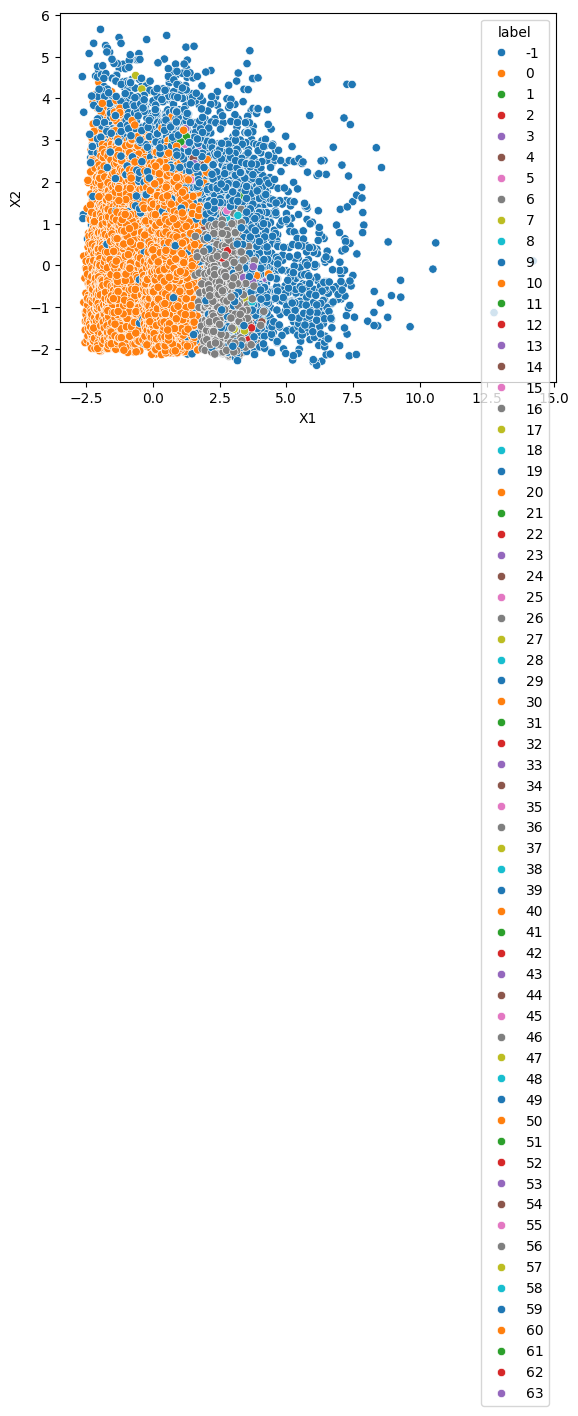

Quantidade de pontos em cada clusters:
 0     26502
-1      4130
 36     1505
 47       23
 21       17
       ...  
 57        4
 28        4
 62        3
 61        3
 30        3
Name: count, Length: 65, dtype: int64


In [133]:
df_result, n_clusters = plot_dbscan(X_df,
                                   eps = 0.5,
                                   min_pts = 5)

DBSCAN com eps=0.1 e minPts=5
Número de clusters: 8


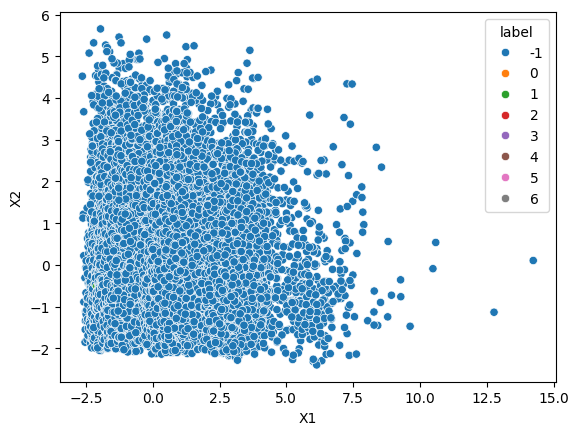

Quantidade de pontos em cada clusters:
-1    32536
 1        7
 6        7
 2        6
 0        5
 3        5
 4        5
 5        5
Name: count, dtype: int64
DBSCAN com eps=0.2 e minPts=5
Número de clusters: 304


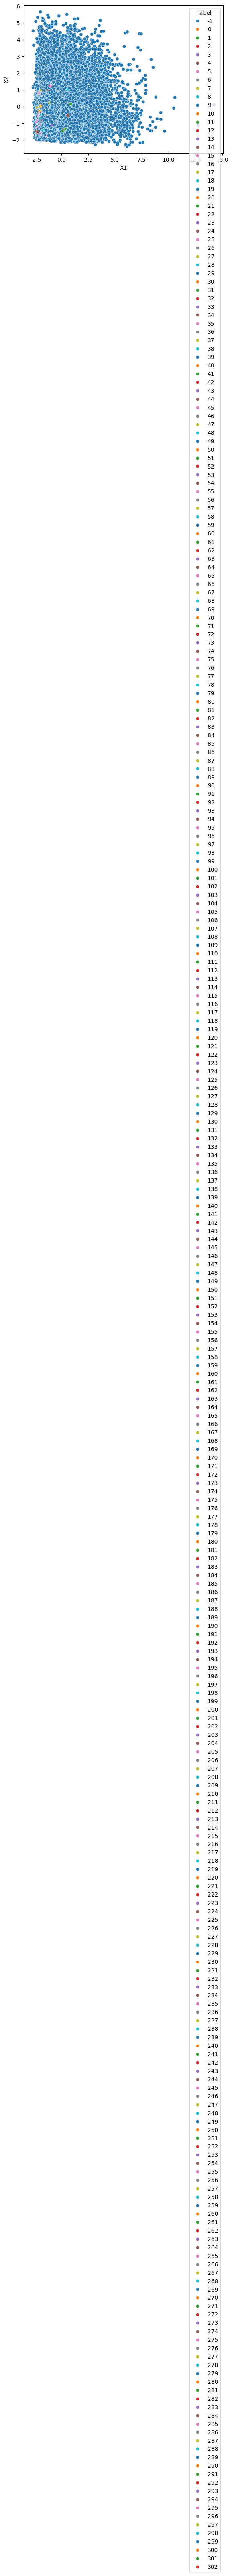

Quantidade de pontos em cada clusters:
-1      29466
 21       193
 19       120
 13       109
 15       102
        ...  
 107        4
 227        3
 274        3
 161        3
 88         3
Name: count, Length: 304, dtype: int64
DBSCAN com eps=0.30000000000000004 e minPts=5
Número de clusters: 305


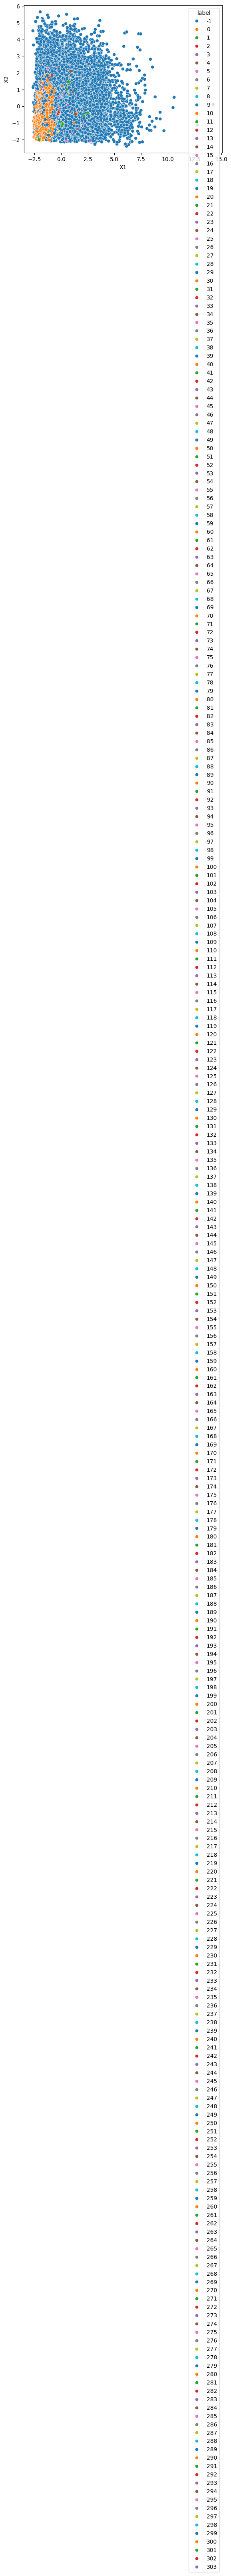

Quantidade de pontos em cada clusters:
-1      17233
 0      10098
 139     2333
 16       704
 174       53
        ...  
 210        2
 96         2
 245        2
 232        2
 32         2
Name: count, Length: 305, dtype: int64
DBSCAN com eps=0.4 e minPts=5
Número de clusters: 136


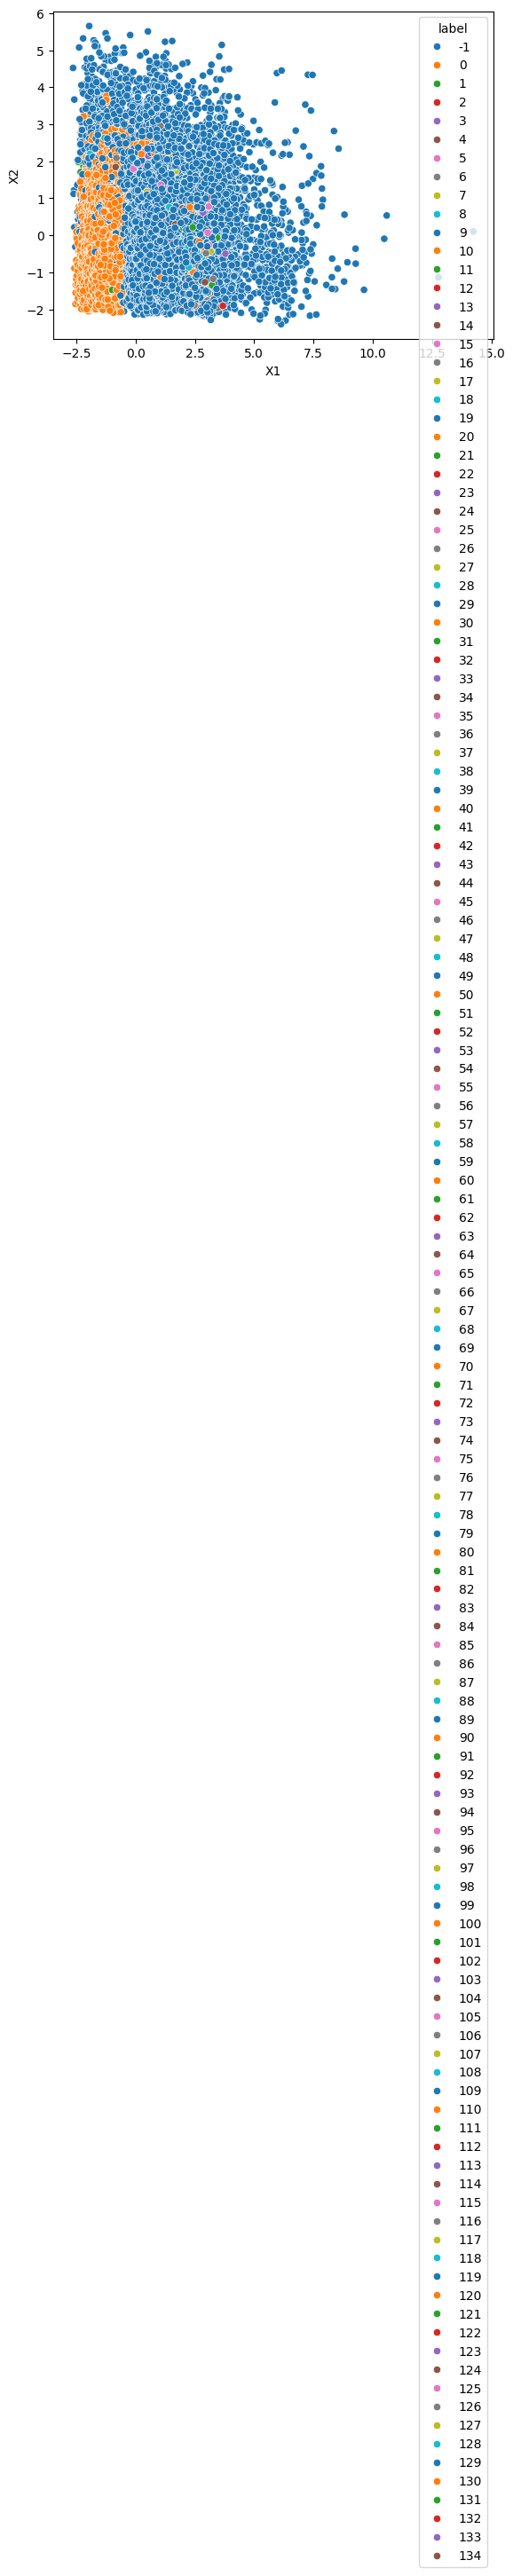

Quantidade de pontos em cada clusters:
 0      15757
-1       8044
 39      7239
 99       480
 106       73
        ...  
 117        3
 94         3
 25         3
 31         2
 126        2
Name: count, Length: 136, dtype: int64
DBSCAN com eps=0.5 e minPts=5
Número de clusters: 65


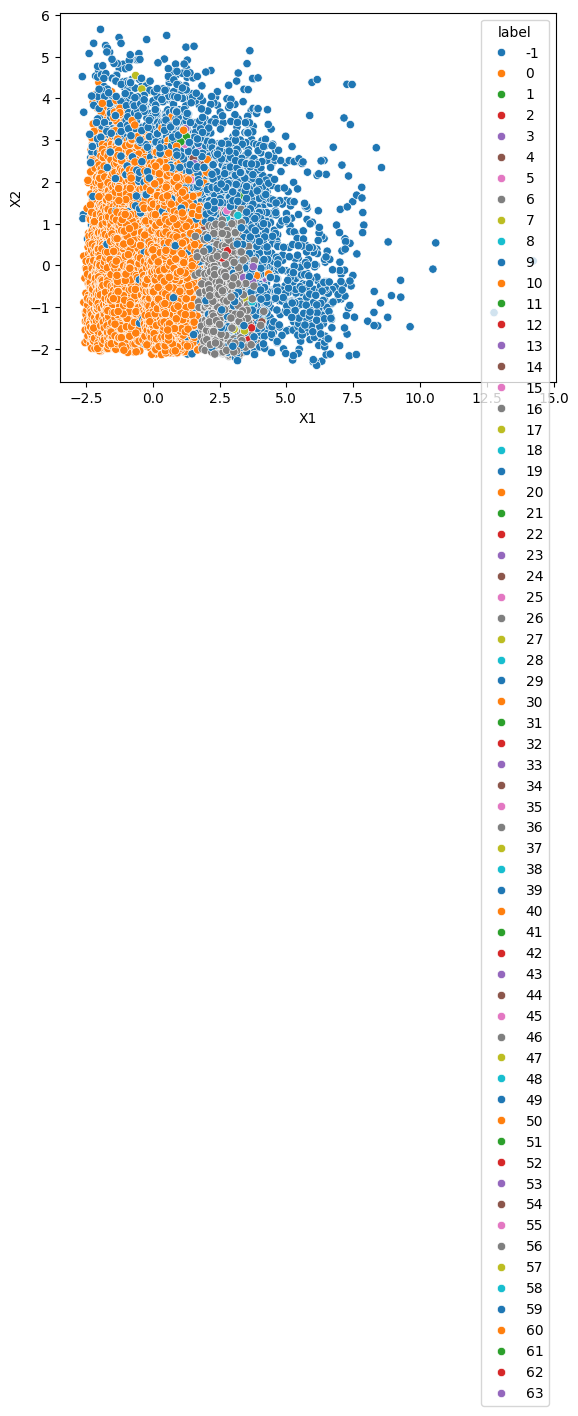

Quantidade de pontos em cada clusters:
 0     26502
-1      4130
 36     1505
 47       23
 21       17
       ...  
 57        4
 28        4
 62        3
 61        3
 30        3
Name: count, Length: 65, dtype: int64


In [134]:
# variando o eps
eps_values = np.linspace(0.1, 0.5, 5)
n_clusters = []

for eps in eps_values:
    _, n = plot_dbscan(X_df, eps = eps, min_pts = 5)
    n_clusters.append(n)

In [135]:
df_cluster_f = pd.concat([df_cluster_f, df_emprestimo['taxa_juros'].reset_index(drop=True)], axis=1)

In [136]:
df_cluster_f

index  idade   renda        moradia  tempo_empregado motivo_emp  \
0          0     22   59000        aluguel              0.0    pessoal   
1          1     21    9600        propria              5.0   educacao   
2          2     25    9600  financiamento              1.0      saude   
3          3     23   65500        aluguel              4.0      saude   
4          4     24   54400        aluguel              8.0      saude   
...      ...    ...     ...            ...              ...        ...   
32571  32576     57   53000  financiamento              1.0    pessoal   
32572  32577     54  120000  financiamento              4.0    pessoal   
32573  32578     65   76000        aluguel              3.0    reforma   
32574  32579     56  150000  financiamento              5.0    pessoal   
32575  32580     66   42000        aluguel              2.0      saude   

      risco_emp  valor_emp  emp/renda hist_inadimplencia  tempo_emp_hist  \
0             D      35000       0.59                  Y               3   
1             B       1000       0.10                  N               2   
2             C       5500       0.57                  N               3   
3             C      35000       0.53                  N               2   
4             C      35000       0.55                  Y               4   
...         ...        ...        ...                ...             ...   
32571         C       5800       0.11                  N              30   
32572         A      17625       0.15                  N              19   
32573         B      35000       0.46                  N              28   
32574         B      15000       0.10                  N              26   
32575         B       6475       0.15                  N              30   

       label  taxa_juros  
0          0       16.02  
1          2       11.14  
2          0       12.87  
3          0       15.23  
4          0       14.27  
...      ...         ...  
32571      3       13.16  
32572      3        7.49  
32573      3       10.99  
32574      3       11.48  
32575      3        9.99  

[32576 rows x 13 columns]

In [137]:
df_cluster_f.groupby('label')['taxa_juros'].mean()

label
0    11.866481
1    10.798616
2    10.677256
3    11.160859
Name: taxa_juros, dtype: float64

In [138]:
df_cluster_f.groupby('label')['taxa_juros'].std()

label
0    3.185882
1    3.208228
2    3.200946
3    3.274912
Name: taxa_juros, dtype: float64

In [139]:
df_cluster_f.groupby('label')['taxa_juros'].mean()

label
0    11.866481
1    10.798616
2    10.677256
3    11.160859
Name: taxa_juros, dtype: float64

In [140]:
df_cluster_f.groupby('risco_emp')['taxa_juros'].mean()

risco_emp
A     7.327651
B    10.995542
C    13.463649
D    15.361448
E    17.009455
F    18.609159
G    20.251525
Name: taxa_juros, dtype: float64

In [141]:
df_cluster_f['risco_emp'].value_counts()

risco_emp
A    10777
B    10448
C     6456
D     3626
E      964
F      241
G       64
Name: count, dtype: int64

In [142]:
df_cluster_f.groupby('risco_emp')['taxa_juros'].std()

risco_emp
A    1.043984
B    0.909478
C    0.961999
D    1.111152
E    1.323164
F    1.375524
G    1.066830
Name: taxa_juros, dtype: float64

In [143]:
df_cluster_f['label'].value_counts()

label
2    13112
1     9197
0     6815
3     3452
Name: count, dtype: int64